In [1]:
%load_ext autoreload
%autoreload 2
from dpe import DPE
from lib_data import *
import matplotlib.pyplot as plt
import numpy as np
from lib_nn_dpe import NN_dpe
from IPython import display

load_workspace(vars(), 'dataset/20190815-132601-weights')
load_workspace(vars(), 'dataset/mnist')

Loaded: weights, 
Loaded: train_images, train_labels, test_images, test_labels, 


In [2]:
dpe = DPE('COM6')

Running <function DPE.init_dut at 0x0E0C2978> with serial
DAC initialized to a span from -10 V to 10 V
Setting vrefs to default
[INFO] Elapsed time = 0.04s
Serial disconnected


In [3]:
dpe.set_clock(50)

Running <function DPE.set_clock at 0x0E0C2A08> with serial
Setting ADC_CK freq=50000.0kHz
Setting CK_ARRAY freq=50000.0kHz
[INFO] Elapsed time = 0.00s
Serial disconnected


In [4]:
g = dpe.read(1)

Running <function DPE.read at 0x0E0C2A98> with serial
[INFO] Elapsed time = 0.25s
Serial disconnected


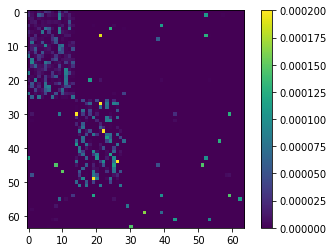

In [5]:
plt.imshow(g)
plt.clim(0, 2e-4)
plt.colorbar()

In [6]:
nn = NN_dpe(weights)

In [ ]:
img_idx = 6

image = test_images[img_idx]
vectors = nn._conv_flattern(image)
vectors.max()

In [20]:
outputs = dpe.multiply(1, vectors, c_sel=[0, 14]) / (nn.Gratio/2) / 0.2

Connecting to serial
[INFO] Elapsed time = 1.49s
Serial disconnected


In [21]:
outputs.shape

(400, 14)

In [24]:
software = (finalGconv.T @ vectors).T / (nn.Gratio/2)

In [ ]:
for c in range(14):
    x = []
    y = []
        
    plt.figure(c+1)
    plt.title(f'Column {c}')
    plt.plot(outputs[:,c],software[:,c], '.', alpha=0.3)
    plt.xlabel('Expectation')

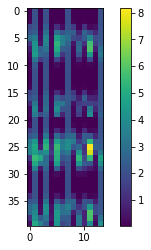

In [26]:
plt.imshow(software[:40])
plt.colorbar()

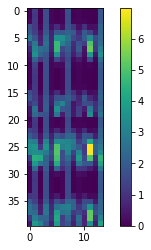

In [27]:
plt.imshow(outputs[:40])
plt.colorbar()

In [28]:
linear_factors_conv = []
for c in range(14):
    linear_factors_conv.append( np.polyfit(outputs[:,c], software[:,c], 1))
    
linear_factors_conv = np.array(linear_factors_conv)
linear_factors_conv

array([[ 1.10600809,  0.02558262],
       [ 1.0400355 ,  0.85863644],
       [ 1.30230276,  0.00215507],
       [ 1.44122246, -0.16235268],
       [ 1.23063979, -0.09618758],
       [ 1.08255167,  0.03345652],
       [ 1.10381478, -0.07628634],
       [ 1.23586714,  0.08344223],
       [ 1.06021022, -0.08062452],
       [ 1.37758174, -0.16723768],
       [ 1.17893294,  0.0187636 ],
       [ 1.12354446,  0.03942665],
       [ 1.22563643,  0.01260009],
       [ 0.79969926,  0.41632605]])

In [29]:
for c in range(outputs.shape[1]):
    outputs[:,c] = outputs[:,c] * linear_factors_conv[c][0] + linear_factors_conv[c][1]

In [31]:
result = outputs[:, ::2] - outputs[:,1::2]
x = result.reshape(20,20,-1)
# for i in range(7):
#     plt.figure(i)
#     plt.imshow(x[:,:,i])
#     plt.colorbar()

In [32]:
x1 = nn.relu(x)
x1 = nn.max_pooling(x1)
x1 = nn.flattern(x1)
y = nn.dense(x1)

print('predicted', y.argmax())
print('label', test_labels[img_idx])

predicted 4
label 4


In [ ]:
xs = []
acc = []

for img_idx in range(len(test_images)):
    
    
    image = test_images[img_idx]
    vectors = nn._conv_flattern(image)
    
    outputs = dpe.multiply(1, vectors, c_sel=[0, 14]) / (nn.Gratio/2) / 0.2
    
    for c in range(outputs.shape[1]):
        outputs[:,c] = outputs[:,c] * linear_factors_conv[c][0] + linear_factors_conv[c][1]
    
    result = outputs[:, ::2] - outputs[:,1::2]
    x = result.reshape(20,20,-1)
    
    x1 = nn.relu(x)
    x1 = nn.max_pooling(x1)
    x1 = nn.flattern(x1)
    
    xs.append(x1)
    y = nn.dense(x1)
    
    display.clear_output(wait=True)

    print(f'idx={img_idx}, predicted: {y.argmax()}, label: {test_labels[img_idx]}')
    acc.append( y.argmax() == test_labels[img_idx] )
    print(f'\t Accuracy = {np.mean(acc)*100:.2f}%')
    
save_workspace(vars(), note='mnist_xs')

In [7]:
load_workspace(vars(), '20190821-051552-mnist_xs')

# load_workspace(vars(), 'mnist_xs_software')
xs = np.array(xs)

Loaded: In, Out, weights, train_images, train_labels, test_images, test_labels, g, img_idx, image, vectors, outputs, software, c, x, y, mat_contents, finalGconv, g1, g2, linear_factors_conv, xs, acc, result, x1, 


In [8]:
# Check xs 
acc = []

for img_idx in range(len(test_images)):
    x1 = xs[img_idx]
    y = nn.dense(x1)
    
    if (img_idx+1)%100 == 0:
        display.clear_output(wait=True)

        print(f'idx={img_idx}, predicted: {y.argmax()}, label: {test_labels[img_idx]}')
        acc.append( y.argmax() == test_labels[img_idx] )
        print(f'\t Accuracy = {np.mean(acc)*100:.2f}%')

idx=9999, predicted: 6, label: 6
	 Accuracy = 98.00%


In [9]:
xs

array([[ 1.43760178, -0.        ,  2.6677077 , ..., -0.        ,
        -0.        , -0.        ],
       [ 0.40300978,  0.68757231,  2.79176243, ..., -0.        ,
         3.54113916,  2.61077068],
       [-0.        , -0.        ,  0.06726302, ..., -0.        ,
        -0.        , -0.        ],
       ...,
       [-0.        , -0.        ,  0.11108644, ..., -0.        ,
        -0.        , -0.        ],
       [-0.        , -0.        ,  0.11126897, ..., -0.        ,
        -0.        , -0.        ],
       [-0.        , -0.        ,  0.79958419, ..., -0.        ,
         3.2943451 ,  1.30286908]])

In [10]:
xs = np.array(xs)
xs.shape

(10000, 112)

In [11]:
xs = np.concatenate((xs, np.ones((xs.shape[0], 1))), axis=1)

In [12]:
xs.shape

(10000, 113)

Running <function DPE.read at 0x0E0C2A98> with serial
[INFO] Elapsed time = 0.26s
Serial disconnected


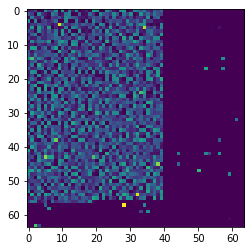

In [13]:
plt.imshow(dpe.read(2))

In [14]:
x = xs[0:400]

x1 = x[:,:57].T
x2 = x[:,57:].T

sc1 = x1.max()
sc2 = x2.max()

Gfc1 = nn.Gfc[:57]
Gfc2 = nn.Gfc[57:]

x1 = x1 / sc1
x2 = x2 / sc2

In [83]:
dpe.N_BIT = 8

output1 = dpe.multiply(2, x1, c_sel=[0, 20], mode=1)
software1 = (Gfc1.T @ x1).T 

output2 = dpe.multiply(2, x2, c_sel=[20, 40], mode=1)
software2 = (Gfc2.T @ x2).T 

Running <function DPE.multiply at 0x0E0C2CD8> with serial
[INFO] Elapsed time = 3.73s
Serial disconnected
Running <function DPE.multiply at 0x0E0C2CD8> with serial
[INFO] Elapsed time = 3.69s
Serial disconnected


In [75]:
# dpe.N_BIT = 8
# output1 = dpe.multiply_w_delay(2, x1, c_sel=[0, 20], mode=1, debug=True, delay=5)
# software1 = (Gfc1.T @ x1).T 

# output2 = dpe.multiply_w_delay(2, x2, c_sel=[20, 40], mode=1, debug=True, delay=5)
# software2 = (Gfc2.T @ x2).T 

In [76]:
lin_cor_fc1 = []
lin_cor_fc2 = []
for c in range(20):
    lin_cor_fc1.append( np.polyfit(output1[:,c], software1[:,c], 1))
    lin_cor_fc2.append( np.polyfit(output2[:,c], software2[:,c], 1))

In [84]:
output_sum = output1 + output2
output_sub = output_sum[:,::2] - output_sum[:,1::2]

software_sum = (software1 + software2)
software_sub = software_sum[:,::2] - software_sum[:,1::2]

lin_cor_fc = []
for c in range(10):
    lin_cor_fc.append( np.polyfit(output_sub[:,c], software_sub[:,c], 1) ) 

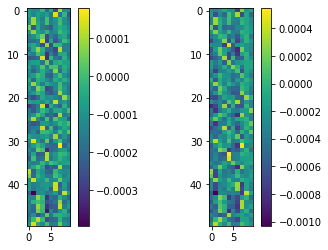

In [92]:
plt.subplot(121)
plt.imshow(output_sub[:50])
plt.colorbar()
plt.subplot(122)
plt.imshow(software_sub[:50])
plt.colorbar()

In [99]:
np.array(lin_cor_fc)

array([[ 2.59498036e+00, -3.19849203e-05],
       [ 2.59834724e+00, -8.16180497e-05],
       [ 2.43377966e+00, -3.42954044e-06],
       [ 2.64287963e+00, -5.23853937e-05],
       [ 2.46904526e+00,  1.14135033e-04],
       [ 2.57160874e+00,  7.24967353e-05],
       [ 2.89613465e+00, -7.61914001e-05],
       [ 2.85696028e+00, -5.67791126e-05],
       [ 2.11054916e+00,  7.35708679e-05],
       [ 2.05104452e+00,  1.87050994e-05]])

In [98]:
def lin_corr(outputs, factors):
    result = np.zeros(outputs.shape)
    for c in range(outputs.shape[1]):
        result[:,c] = outputs[:,c] * factors[c][0] + factors[c][1]
        
    return result

In [102]:
output_cor = lin_corr(output_sub, lin_cor_fc)

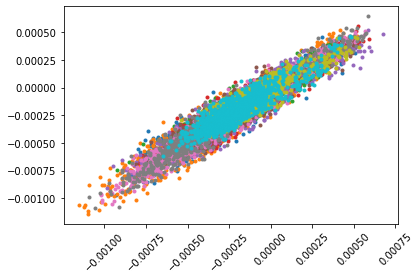

In [103]:
for c in range(10):
    x = software_sub[:,c]
    y = output_cor[:,c]
    
    plt.plot(x,y,'.')
    plt.xticks(rotation=45)

#     lin_cor_fc2.append( np.polyfit(y, x, 1))

In [53]:
outputs = dpe.multiply(0, x2, c_sel=[20, 40], mode=0) 
outputs = lin_corr(outputs, lin_cor_fc2)
software = (Gfc2.T @ x2).T 

Running <function DPE.multiply at 0x0E0C2CD8> with serial
[INFO] Elapsed time = 4.19s
Serial disconnected


In [54]:
# outputs = dpe.multiply_w_delay(2, x2, c_sel=[20, 40], mode=1, debug=True, delay=5)
output_corr = lin_corr(output2, lin_cor_fc2)
software = (Gfc2.T @ x2).T 

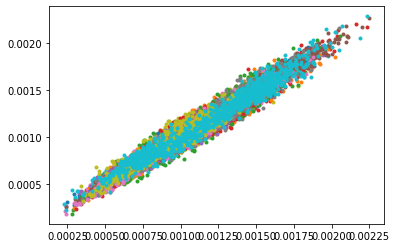

In [55]:
# lin_cor_fc2 = []

for c in range(20):
    x = software[:,c]
    y = output_corr[:,c]
    
    plt.plot(x,y,'.')

#     lin_cor_fc2.append( np.polyfit(y, x, 1))

(array([1.000e+00, 0.000e+00, 6.000e+00, 4.000e+00, 5.000e+00, 1.100e+01,
        2.100e+01, 3.200e+01, 4.500e+01, 7.000e+01, 1.010e+02, 1.420e+02,
        1.930e+02, 2.570e+02, 3.620e+02, 5.030e+02, 5.620e+02, 7.160e+02,
        8.120e+02, 9.570e+02, 1.109e+03, 1.223e+03, 1.308e+03, 1.309e+03,
        1.312e+03, 1.295e+03, 1.281e+03, 1.131e+03, 1.059e+03, 8.590e+02,
        7.400e+02, 6.160e+02, 4.630e+02, 3.710e+02, 3.240e+02, 2.590e+02,
        1.460e+02, 1.140e+02, 9.200e+01, 6.300e+01, 3.500e+01, 2.700e+01,
        2.900e+01, 1.200e+01, 1.000e+01, 3.000e+00, 6.000e+00, 3.000e+00,
        0.000e+00, 1.000e+00]),
 array([-0.10408473, -0.09978717, -0.09548961, -0.09119206, -0.0868945 ,
        -0.08259694, -0.07829939, -0.07400183, -0.06970427, -0.06540672,
        -0.06110916, -0.0568116 , -0.05251405, -0.04821649, -0.04391893,
        -0.03962138, -0.03532382, -0.03102626, -0.02672871, -0.02243115,
        -0.01813359, -0.01383604, -0.00953848, -0.00524092, -0.00094337,
         0.

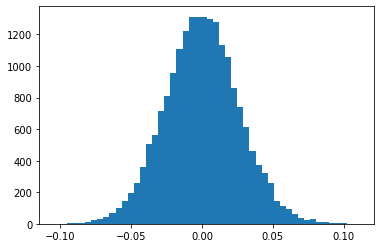

In [56]:
plt.hist((output_corr-software).reshape(-1, 1)/0.0025, bins=50 )

In [57]:
(output_corr-software).reshape(-1, 1).std()/0.00225

0.02902467889301626

In [58]:
# load_workspace(vars(), '20190821-051552-mnist_xs')
# xs = np.array(xs)

In [60]:
ys = []
batch_size = 1000

for i in range( (len(test_images)-1)//batch_size + 1 ):
    idx1 = i * batch_size
    idx2 = (i+1) * batch_size
    idx2 = idx2 if idx2<= len(test_images) else len(test_images)
    
    print(f'Running on sample {idx1}-{idx2}')

    x = xs[idx1:idx2]

    x1 = x[:,:57].T
    x2 = x[:,57:].T

    sc1 = x1.max()
    sc2 = x2.max()

    Gfc1 = nn.Gfc[:57]
    Gfc2 = nn.Gfc[57:]

    x1 = x1 / sc1
    x2 = x2 / sc2
    
    output1  = dpe.multiply(2, x1, c_sel=[0, 20], mode=1)
    output1 = lin_corr(output1, lin_cor_fc1) * sc1

    output2  = dpe.multiply(2, x2, c_sel=[20, 40], mode=1)
    output2 = lin_corr(output2, lin_cor_fc2) * sc2

    outputs = output1 + output2
    
    y = outputs[:,::2] - outputs[:,1::2]
    
    display.clear_output(wait=True)
    
    print(f'Batch accuracy = {np.mean(y.argmax(axis=1) == test_labels[idx1:idx2])*100:.2f}%')
    ys.append(y)
    print(f'Overall = {np.mean(np.concatenate(ys).argmax(axis=1) == test_labels[:idx2])*100:.2f}%')
    
ys = np.concatenate(ys)  

Batch accuracy = 92.40%
Overall = 92.23%


In [61]:
np.mean(ys.argmax(axis=1) == test_labels)

0.9223

In [75]:
save_workspace(vars(), note='prober1-oriFC')

Saving In(<class 'list'>), Out(<class 'dict'>), weights(<class 'numpy.ndarray'>), train_images(<class 'numpy.ndarray'>), train_labels(<class 'numpy.ndarray'>), test_images(<class 'numpy.ndarray'>), test_labels(<class 'numpy.ndarray'>), g(<class 'numpy.ndarray'>), img_idx(<class 'int'>), image(<class 'numpy.ndarray'>), vectors(<class 'numpy.ndarray'>), outputs(<class 'numpy.ndarray'>), software(<class 'numpy.ndarray'>), c(<class 'int'>), x(<class 'numpy.ndarray'>), y(<class 'numpy.ndarray'>), mat_contents(<class 'dict'>), finalGconv(<class 'numpy.ndarray'>), g1(<class 'numpy.ndarray'>), g2(<class 'numpy.ndarray'>), linear_factors_conv(<class 'numpy.ndarray'>), xs(<class 'numpy.ndarray'>), acc(<class 'list'>), result(<class 'numpy.ndarray'>), x1(<class 'numpy.ndarray'>), x2(<class 'numpy.ndarray'>), sc1(<class 'numpy.float64'>), sc2(<class 'numpy.float64'>), Gfc1(<class 'numpy.ndarray'>), Gfc2(<class 'numpy.ndarray'>), output1(<class 'numpy.ndarray'>), software1(<class 'numpy.ndarray'>),

In [29]:
ynew.argmax(axis=1) == test_labels

array([ True,  True, False, ...,  True,  True,  True])

In [23]:
import scipy.io as sio
#load_workspace(vars(), '20190814-205207-CNN weights')
mat_contents = sio.loadmat('UpdatedGconv.mat')
finalGconv = mat_contents['finalGconv']

In [104]:
# Linear correction after subtraction

ys = []
batch_size = 1000

for i in range( (len(test_images)-1)//batch_size + 1 ):
    idx1 = i * batch_size
    idx2 = (i+1) * batch_size
    idx2 = idx2 if idx2<= len(test_images) else len(test_images)
    
    print(f'Running on sample {idx1}-{idx2}')

    x = xs[idx1:idx2]

    x1 = x[:,:57].T
    x2 = x[:,57:].T

    sc1 = x1.max()
    sc2 = x2.max()

    Gfc1 = nn.Gfc[:57]
    Gfc2 = nn.Gfc[57:]

    x1 = x1 / sc1
    x2 = x2 / sc2
    
    output1  = dpe.multiply(2, x1, c_sel=[0, 20], mode=1) * sc1
#     output1 = lin_corr(output1, lin_cor_fc1) * sc1

    output2  = dpe.multiply(2, x2, c_sel=[20, 40], mode=1) * sc2
#     output2 = lin_corr(output2, lin_cor_fc2) * sc2

    outputs = output1 + output2
    
    y = outputs[:,::2] - outputs[:,1::2]
    
    y = lin_corr(y, lin_cor_fc)
    
    display.clear_output(wait=True)
    
    print(f'Batch accuracy = {np.mean(y.argmax(axis=1) == test_labels[idx1:idx2])*100:.2f}%')
    ys.append(y)
    print(f'Overall = {np.mean(np.concatenate(ys).argmax(axis=1) == test_labels[:idx2])*100:.2f}%')
    
ys = np.concatenate(ys)  

Batch accuracy = 89.00%
Overall = 89.61%
